### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import SpanSelector

In [2]:
import h5py
import numpy as np
import pandas as pd
from matplotlib.widgets import RangeSlider
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetRegressor

### Load Data

In [3]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

In [4]:
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")

valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

### Process Data

In [5]:
spectra_filtered = spectra[mask]
images_filtered = images[mask]
metadata_indices_filtered = metadata_indices[mask]

In [6]:
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]
redshifts = valid_sfrs.loc[metadata_indices_filtered, "Z"].values

In [7]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    return "GALAXY" if "GALAXY" in val else "OTHER"

In [8]:
labels_simplified = pd.Series(labels).apply(simplify_targettype).values

In [9]:
galaxy_mask = labels_simplified == "GALAXY"
spectra_filtered = spectra_filtered[galaxy_mask]
images_filtered = images_filtered[galaxy_mask]
redshifts = redshifts[galaxy_mask]

nan_mask = ~np.isnan(spectra_filtered).any(axis=1)
spectra_filtered = spectra_filtered[nan_mask]
images_filtered = images_filtered[nan_mask]
redshifts = redshifts[nan_mask]

In [10]:
def normalize_spectra(spec):
    min_val = np.min(spec, axis=1, keepdims=True)
    max_val = np.max(spec, axis=1, keepdims=True)
    return 2 * (spec - min_val) / (max_val - min_val) - 1

spectra_normalized = normalize_spectra(spectra_filtered)

In [11]:
filters = ["u", "g", "r", "i", "z"]

def plot_images_and_spectrum(images, spectra, labels, redshifts, class_name, obj_num):
    class_index = np.where(labels == class_name)[0]
    if len(class_index) > 0:
        idx = class_index[obj_num]
        img_channels = images[idx]
        spectrum = spectra[idx]
        redshift = redshifts[idx] if not np.isnan(redshifts[idx]) else "N/A"
        
        fig = plt.figure(figsize=(15, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.5])
        gs_images = gs[0].subgridspec(1, 5, wspace=0.1)
        
        for i in range(5):
            ax = fig.add_subplot(gs_images[0, i])
            ax.imshow(img_channels[i], cmap="viridis")
            ax.set_title(f"{class_name} - {filters[i]}", fontsize=9)
            ax.axis("off")
        
        ax_spec = fig.add_subplot(gs[1])
        wavelengths = np.linspace(3800, 9200, len(spectrum))
        ax_spec.plot(wavelengths, spectrum, color="blue", linewidth=0.3)
        ax_spec.set_title(f"{class_name} - Spectrum (z={redshift:.3f})", fontsize=9)
        ax_spec.set_xlabel("Wavelength (Å)", fontsize=9)
        ax_spec.set_ylabel("Flux", fontsize=9)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No images found for class: {class_name}")

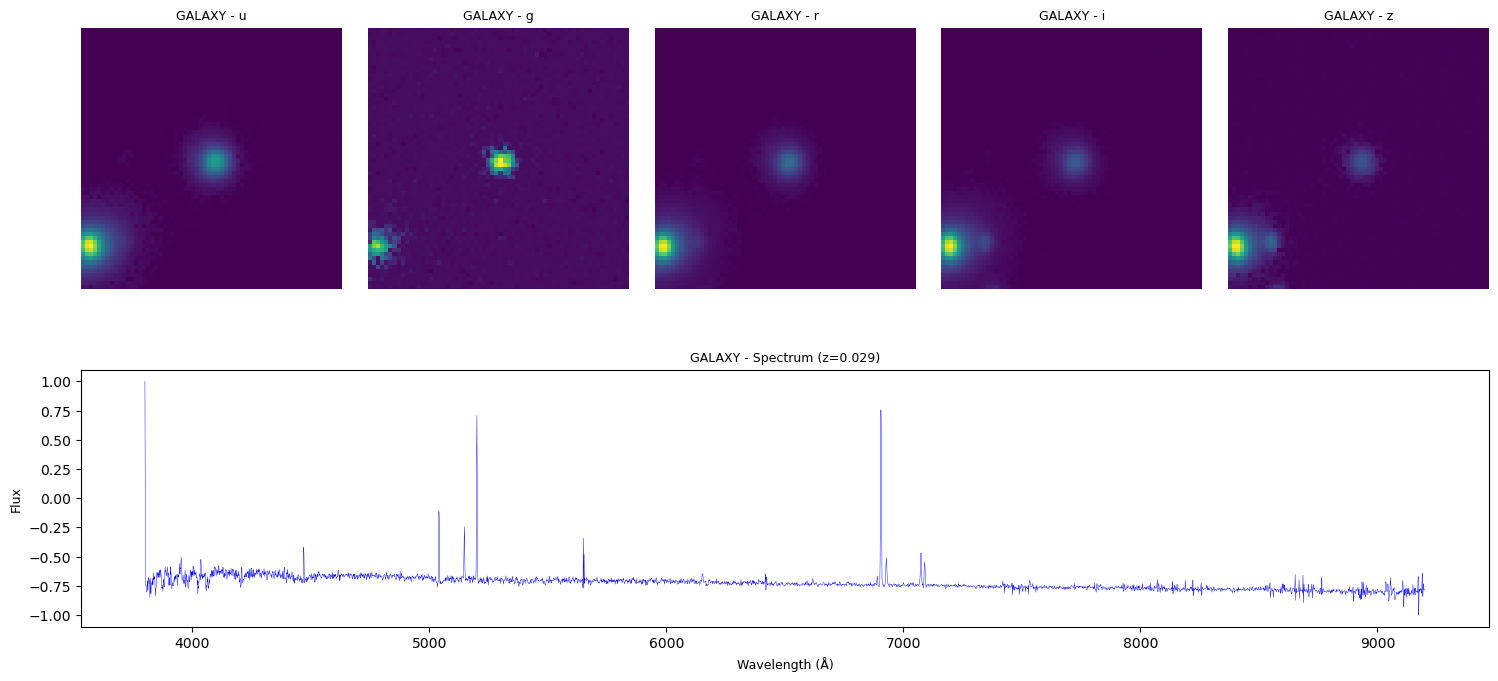

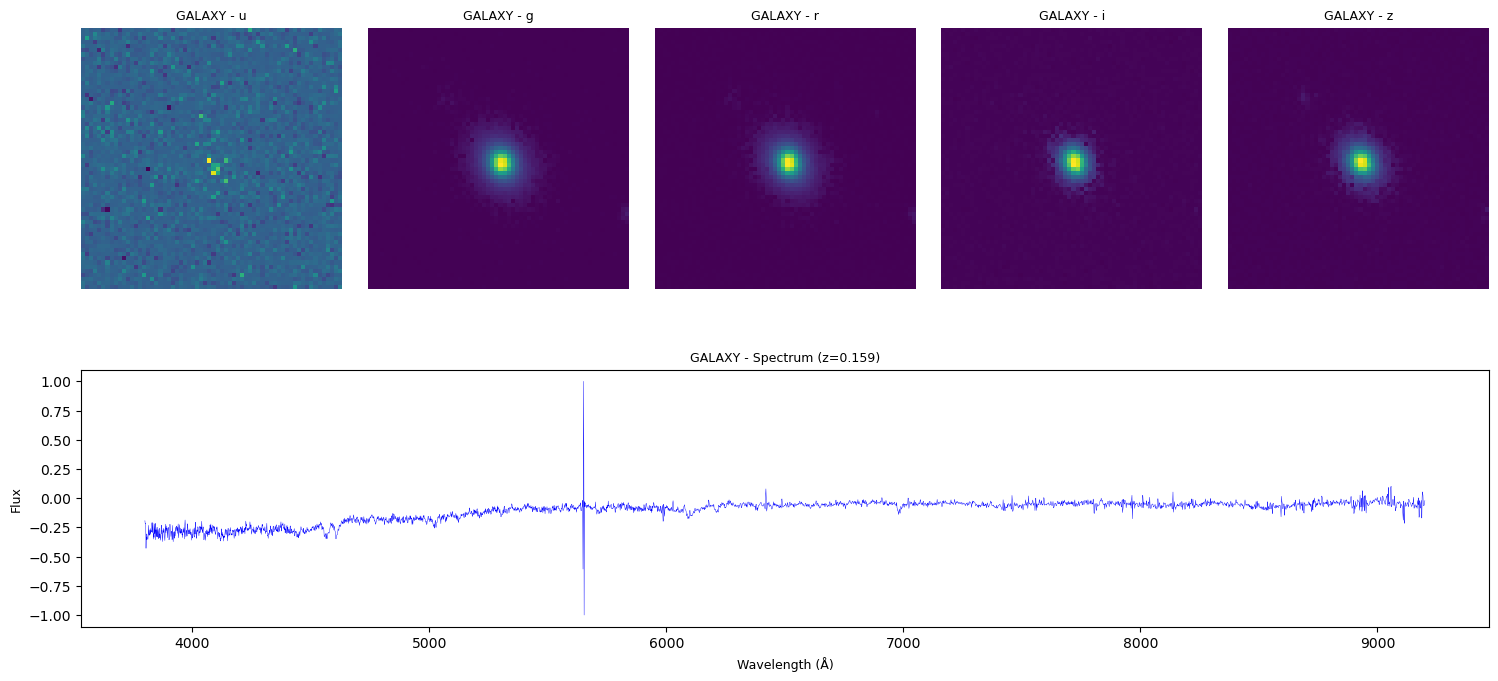

In [12]:
for i in range(2):
    plot_images_and_spectrum(images_filtered, spectra_normalized, labels_simplified, redshifts, "GALAXY", i)

# Machine Learning for SFR

In [13]:
y = valid_sfrs.loc[metadata_indices_filtered, ["AVG", "ENTROPY", "MEDIAN", "MODE", "P16", "P2P5", "P84", "P97P5"]].values
y = y[galaxy_mask]
y = y[nan_mask]

In [14]:
column_descriptions = {
    "AVG": "Mean value of the SFR distribution",
    "ENTROPY": "Entropy of the SFR distribution (measure of uncertainty)",
    "MEDIAN": "Median value of SFR",
    "MODE": "Mode value (most probable SFR)",
    "P16": "16th percentile (lower bound of 1σ)",
    "P2P5": "2.5th percentile (lower bound of 2σ)",
    "P84": "84th percentile (upper bound of 1σ)",
    "P97P5": "97.5th percentile (upper bound of 2σ)"
}

for col, desc in column_descriptions.items():
    print(f"{col}: {desc}")

AVG: Mean value of the SFR distribution
ENTROPY: Entropy of the SFR distribution (measure of uncertainty)
MEDIAN: Median value of SFR
MODE: Mode value (most probable SFR)
P16: 16th percentile (lower bound of 1σ)
P2P5: 2.5th percentile (lower bound of 2σ)
P84: 84th percentile (upper bound of 1σ)
P97P5: 97.5th percentile (upper bound of 2σ)


In [19]:
y_df = pd.DataFrame(y, columns=["AVG", 'AVG', 'AVG',"AVG", 'AVG', 'AVG', 'AVG', 'AVG']

plt.figure(figsize=(12, 6))
for col in y_df.columns:
    sns.histplot(y_df[col], kde=True, label=col, bins=50, alpha=0.6)
plt.legend()
plt.title("Distribution of SFR values across different estimates")
plt.xlabel("SFR Value")
plt.ylabel("Frequency")
plt.show()

SyntaxError: invalid syntax (3902133371.py, line 3)

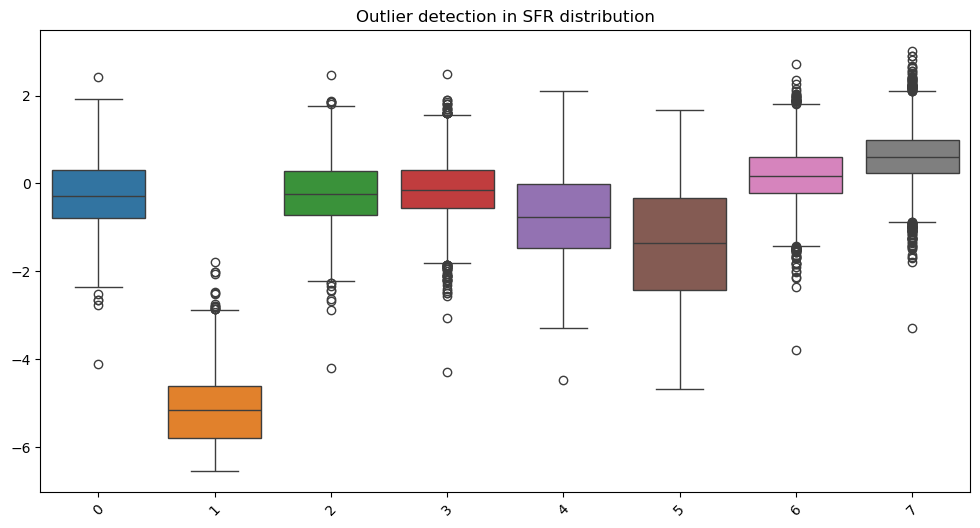

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=y)
plt.xticks(rotation=45)
plt.title("Outlier detection in SFR distribution")
plt.show()

In [17]:
Q1 = y_df.quantile(0.25)
Q3 = y_df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((y_df < (Q1 - 1.5 * IQR)) | (y_df > (Q3 + 1.5 * IQR))).sum()
print("Number of outliers per column:")
print(outliers)

Number of outliers per column:
AVG          6
ENTROPY     16
MEDIAN      15
MODE        58
P16          1
P2P5         0
P84         68
P97P5      113
dtype: int64


In [18]:
indices = np.arange(y.shape[0])
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

In [19]:
y_train, y_test = y[train_idx], y[test_idx]
X_spec_train, X_spec_test = spectra_normalized[train_idx], spectra_normalized[test_idx]
X_photo = images_filtered.reshape(images_filtered.shape[0], -1)
X_photo_train, X_photo_test = X_photo[train_idx], X_photo[test_idx]
X_comb_train = np.concatenate([X_spec_train, X_photo_train], axis=1)
X_comb_test = np.concatenate([X_spec_test, X_photo_test], axis=1)

In [20]:
scaler = StandardScaler()
X_spec_train_scaled = scaler.fit_transform(X_spec_train)
X_spec_test_scaled = scaler.transform(X_spec_test)
X_photo_train_scaled = scaler.fit_transform(X_photo_train)
X_photo_test_scaled = scaler.transform(X_photo_test)
X_comb_train_scaled = scaler.fit_transform(X_comb_train)
X_comb_test_scaled = scaler.transform(X_comb_test)

In [21]:
def train_tabnet(X_train, y_train, X_test):
    model = TabNetRegressor(
        n_d=64, n_a=64, n_steps=6,
        gamma=1.5, lambda_sparse=0.0001,
        momentum=0.7, mask_type="entmax"
    )
    model.fit(X_train, y_train, max_epochs=100, patience=20, batch_size=256, virtual_batch_size=128)
    return model.predict(X_test)

y_pred_spec_tab = train_tabnet(X_spec_train_scaled, y_train, X_spec_test_scaled)
y_pred_photo_tab = train_tabnet(X_photo_train_scaled, y_train, X_photo_test_scaled)
y_pred_comb_tab = train_tabnet(X_comb_train_scaled, y_train, X_comb_test_scaled)

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.14988 |  0:00:02s
epoch 1  | loss: 0.85516 |  0:00:03s
epoch 2  | loss: 0.67352 |  0:00:05s
epoch 3  | loss: 0.59791 |  0:00:06s
epoch 4  | loss: 0.58968 |  0:00:08s
epoch 5  | loss: 0.5788  |  0:00:09s
epoch 6  | loss: 0.57622 |  0:00:10s
epoch 7  | loss: 0.57557 |  0:00:12s
epoch 8  | loss: 0.57464 |  0:00:13s
epoch 9  | loss: 0.58203 |  0:00:14s
epoch 10 | loss: 0.58295 |  0:00:16s
epoch 11 | loss: 0.5784  |  0:00:17s
epoch 12 | loss: 0.57343 |  0:00:18s
epoch 13 | loss: 0.5722  |  0:00:20s
epoch 14 | loss: 0.57733 |  0:00:21s
epoch 15 | loss: 0.57412 |  0:00:22s
epoch 16 | loss: 0.57195 |  0:00:24s
epoch 17 | loss: 0.56745 |  0:00:25s
epoch 18 | loss: 0.57257 |  0:00:26s
epoch 19 | loss: 0.56842 |  0:00:28s
epoch 20 | loss: 0.56855 |  0:00:29s
epoch 21 | loss: 0.57211 |  0:00:30s
epoch 22 | loss: 0.57273 |  0:00:31s
epoch 23 | loss: 0.57067 |  0:00:33s
epoch 24 | loss: 0.57095 |  0:00:34s
epoch 25 | loss: 0.56677 |  0:00:35s
epoch 26 | loss: 0.57347 |  0:00:37s
e

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 8.50312 |  0:00:07s
epoch 1  | loss: 2.65056 |  0:00:14s
epoch 2  | loss: 1.28069 |  0:00:21s
epoch 3  | loss: 1.04478 |  0:00:29s
epoch 4  | loss: 0.72169 |  0:00:36s
epoch 5  | loss: 0.72576 |  0:00:43s
epoch 6  | loss: 0.63942 |  0:00:51s
epoch 7  | loss: 0.62522 |  0:00:58s
epoch 8  | loss: 0.58789 |  0:01:05s
epoch 9  | loss: 0.5746  |  0:01:13s
epoch 10 | loss: 0.56389 |  0:01:20s
epoch 11 | loss: 0.5656  |  0:01:27s
epoch 12 | loss: 0.57191 |  0:01:35s
epoch 13 | loss: 0.56688 |  0:01:42s
epoch 14 | loss: 0.56808 |  0:01:49s
epoch 15 | loss: 0.55925 |  0:01:57s
epoch 16 | loss: 0.5582  |  0:02:04s
epoch 17 | loss: 0.55873 |  0:02:11s
epoch 18 | loss: 0.55636 |  0:02:19s
epoch 19 | loss: 0.55646 |  0:02:26s
epoch 20 | loss: 0.55474 |  0:02:33s
epoch 21 | loss: 0.55578 |  0:02:41s
epoch 22 | loss: 0.55492 |  0:02:48s
epoch 23 | loss: 0.55492 |  0:02:55s
epoch 24 | loss: 0.55345 |  0:03:03s
epoch 25 | loss: 0.55422 |  0:03:10s
epoch 26 | loss: 0.55534 |  0:03:17s
e

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 6.34427 |  0:00:10s
epoch 1  | loss: 2.10003 |  0:00:20s
epoch 2  | loss: 0.97781 |  0:00:31s
epoch 3  | loss: 0.74002 |  0:00:41s
epoch 4  | loss: 0.63841 |  0:00:52s
epoch 5  | loss: 0.60047 |  0:01:02s
epoch 6  | loss: 0.58829 |  0:01:13s
epoch 7  | loss: 0.57238 |  0:01:23s
epoch 8  | loss: 0.56081 |  0:01:34s
epoch 9  | loss: 0.55919 |  0:01:44s
epoch 10 | loss: 0.55453 |  0:01:55s
epoch 11 | loss: 0.54466 |  0:02:05s
epoch 12 | loss: 0.54112 |  0:02:16s
epoch 13 | loss: 0.54074 |  0:02:26s
epoch 14 | loss: 0.53461 |  0:02:37s
epoch 15 | loss: 0.53501 |  0:02:47s
epoch 16 | loss: 0.54132 |  0:02:58s
epoch 17 | loss: 0.53488 |  0:03:08s
epoch 18 | loss: 0.53398 |  0:03:19s
epoch 19 | loss: 0.53653 |  0:03:29s
epoch 20 | loss: 0.53431 |  0:03:39s
epoch 21 | loss: 0.53061 |  0:03:50s
epoch 22 | loss: 0.53083 |  0:04:00s
epoch 23 | loss: 0.53497 |  0:04:11s
epoch 24 | loss: 0.53856 |  0:04:21s
epoch 25 | loss: 0.53971 |  0:04:32s
epoch 26 | loss: 0.5408  |  0:04:42s
e

In [22]:
y_mean = np.full_like(y_test, np.mean(y_train, axis=0))
mae_mean = mean_absolute_error(y_test, y_mean)

mae_spec_tab = mean_absolute_error(y_test, y_pred_spec_tab)
mae_photo_tab = mean_absolute_error(y_test, y_pred_photo_tab)
mae_comb_tab = mean_absolute_error(y_test, y_pred_comb_tab)

print("Mean model MAE:", mae_mean)
print("Spectrum model MAE (TabNet):", mae_spec_tab)
print("Photo model MAE (TabNet):", mae_photo_tab)
print("Combination model MAE (TabNet):", mae_comb_tab)

Mean model MAE: 0.6163717097520727
Spectrum model MAE (TabNet): 0.600662432045415
Photo model MAE (TabNet): 0.5942335839285826
Combination model MAE (TabNet): 0.5759107095394245


In [23]:
df_results = pd.DataFrame({
    "y_test": list(y_test),
    "y_pred_spec_tab": list(y_pred_spec_tab),
    "y_pred_photo_tab": list(y_pred_photo_tab),
    "y_pred_comb_tab": list(y_pred_comb_tab)
})
print(df_results.head(10))

                                              y_test  \
0  [-0.4525999128818512, -5.7508357269963755, -0....   
1  [-0.2147999107837677, -5.758284017535481, -0.1...   
2  [0.37796008586883545, -4.434794977749806, 0.34...   
3  [-1.3138599395751953, -5.47998471566957, -1.26...   
4  [0.4476400911808014, -4.724946891551867, 0.424...   
5  [0.13043010234832764, -4.487824326584547, 0.10...   
6  [0.7521800994873047, -3.3737913659710284, 0.70...   
7  [-1.4386299848556519, -5.80033062012948, -1.34...   
8  [0.07596009224653244, -4.853448751780046, 0.04...   
9  [0.2064300924539566, -4.926453766562226, 0.186...   

                                     y_pred_spec_tab  \
0  [-0.1705588, -5.072708, -0.14922556, -0.062198...   
1  [-0.19304037, -5.16352, -0.16920447, -0.076655...   
2  [-0.21627924, -5.127555, -0.19343194, -0.10543...   
3  [-0.080047525, -4.914178, -0.08413851, -0.0284...   
4  [-0.19347474, -5.2052703, -0.1673536, -0.07019...   
5  [-0.42893583, -5.420605, -0.38588578, -0.253

In [44]:
spectra_normalized.shape

(10126, 4620)